In [147]:
import numpy as np
import scipy
import collections
from save_csv import results_to_csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [148]:
np.random.seed(189)
full_data = np.load("../data/mnist-data-hw3.npz")
data = full_data["training_data"]
data_labels = full_data["training_labels"]

In [149]:
pixel_data = data.reshape(data.shape[0], -1)
shaped_data = np.column_stack((pixel_data, data_labels))
pixel_data.shape, shaped_data.shape

((60000, 784), (60000, 785))

In [150]:
class LDA:
    def __init__(self, data):
        self.gausses = []
        for label in range(10):
            subset = data[data[:, -1] == label]
            subset = subset[:, 0:-1]
            gauss = MLEGaussian(subset=subset, digit=label, data_len=len(data))
            self.gausses.append(gauss)
        
        # calculate pooled covariance matrix
        pooled_cov_matrix = np.zeros((784, 784))
        for gauss in self.gausses:
            subpool = (len(gauss.subset) - 1) * gauss.cov_matrix
            pooled_cov_matrix = pooled_cov_matrix + subpool
        pooled_cov_matrix = pooled_cov_matrix / (len(data) - 10)
        
        # add regularization term so matrix is invertible
        regularization_term = 1e-100 * np.eye(pooled_cov_matrix.shape[0])
        self.pooled_cov_matrix = pooled_cov_matrix + regularization_term
        
    def predict(self, X):
        if X.shape[1] == 785:
            X = X[:, 0:-1] 
            
        # matrix to store discriminant scores for each sample and class so we can vectorize prediction
        scores = np.zeros((X.shape[0], len(self.gausses)))
        
        for digit, gauss in enumerate(self.gausses):
            mu = gauss.mu
            pi_c = gauss.pi_c
            
            score = scipy.stats.multivariate_normal.logpdf(X, allow_singular=True, cov=self.pooled_cov_matrix, mean=mu)+ np.log(pi_c)

            scores[:, digit] = score
            
        return np.argmax(scores, axis=1)

class MLEGaussian:
    def __init__(self, subset, digit, data_len):
        self.subset = subset
        self.digit = digit
        self.pi_c = len(subset) / data_len
        
        # find mean vector and covariance matrix
        self.mu = np.mean(self.subset, axis=0)
        self.cov_matrix = np.cov(self.subset, rowvar=False)
        self.var = np.var(self.subset)
        
        # add regularization term to covariance matrix
        regularization_term = 1e-5 * np.eye(self.cov_matrix.shape[0])
        self.cov_matrix += regularization_term


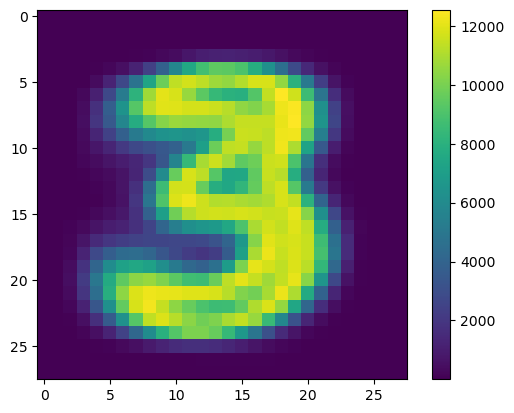

In [151]:
lda = LDA(shaped_data)
gausses = lda.gausses
threes = gausses[3]
cov_matrix = threes.cov_matrix
variances = np.diag(cov_matrix)
var_matrix = variances.reshape(28, 28)

plt.imshow(var_matrix, cmap='viridis')
plt.colorbar()

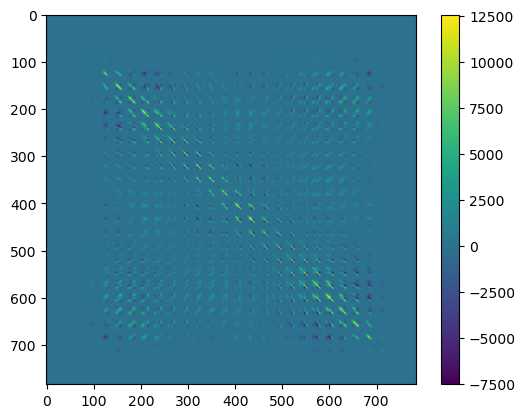

In [152]:
threes = gausses[3]
cov_matrix = threes.cov_matrix

plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar()

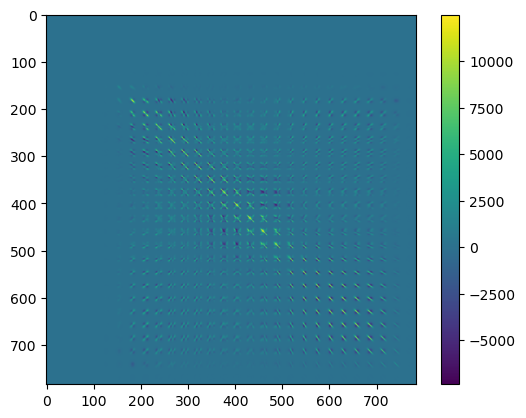

In [153]:
ones = gausses[9]
cov_matrix = ones.cov_matrix

plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar()

In [154]:
X_train, X_test, y_train, y_test = train_test_split(pixel_data, data_labels, test_size=10000, random_state=42)


In [155]:
training = np.column_stack((X_train, y_train))
lda = LDA(training)

predictions = lda.predict(X_test)
accuracy_score(y_test, predictions)

0.8624

In [156]:
lda_accuracies = collections.defaultdict(lambda: {'accuracy': [], 'predictions': []})

EXAMPLE_NUMBERS = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
full_data_copy = np.copy(shaped_data)

for N in EXAMPLE_NUMBERS:
    np.random.shuffle(full_data_copy)
    subset = full_data_copy[0:N]

    lda = LDA(subset)
    predictions = lda.predict(X_test)
    
    acc = accuracy_score(y_test, predictions)
    lda_accuracies[N]['accuracy'].append(acc)
    lda_accuracies[N]['predictions'].append(predictions)

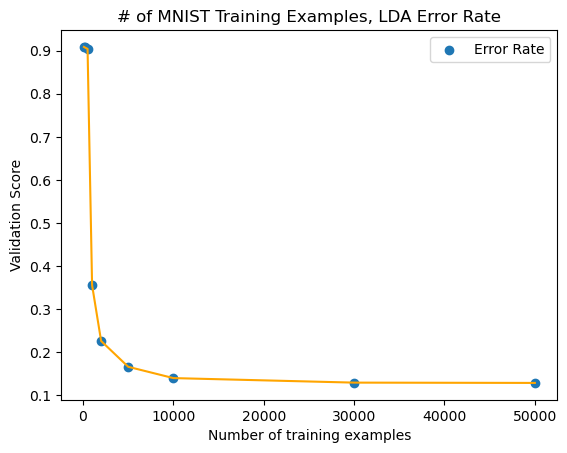

In [ ]:
lda_scores = np.array([lst["accuracy"] for lst in lda_accuracies.values()])
lda_scores = (lda_scores - 1) * -1
plt.scatter(EXAMPLE_NUMBERS, lda_scores, label='Error Rate')
plt.plot(EXAMPLE_NUMBERS, lda_scores, color='orange')
plt.xlabel("Number of training examples")
plt.ylabel("Error Rate")
plt.title("# of MNIST Training Examples, LDA Error Rate")
plt.legend()

In [159]:
class QDA:
    def __init__(self, data):
        self.gausses = []
        for label in range(10):
            subset = data[data[:, -1] == label]
            subset = subset[:, 0:-1]
            gauss = MLEGaussian(subset=subset, digit=label, data_len=len(data))
            self.gausses.append(gauss)
        
    def predict(self, X):
        if X.shape[1] == 785:
            X = X[:, 0:-1] 
            
        # matrix to store discriminant scores for each sample and class so we can vectorize prediction
        scores = np.zeros((X.shape[0], len(self.gausses)))
        
        for digit, gauss in enumerate(self.gausses):
            mu = gauss.mu
            pi_c = gauss.pi_c
            cov_matrix = gauss.cov_matrix

            score = np.array(scipy.stats.multivariate_normal.logpdf(X, allow_singular=True, cov=cov_matrix, mean=mu)
            + np.log(pi_c))
            scores[:, digit] = score

            
        return np.argmax(scores, axis=1)

In [160]:
qda = QDA(training)
predictions = qda.predict(X_test)
accuracy_score(y_test, predictions)

0.8121

In [161]:
qda_accuracies = collections.defaultdict(lambda: {'accuracy': [], 'predictions': []})

EXAMPLE_NUMBERS = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
full_data_copy = np.copy(shaped_data)

for N in EXAMPLE_NUMBERS:
    np.random.shuffle(full_data_copy)
    subset = full_data_copy[0:N]

    qda = QDA(subset)
    predictions = qda.predict(X_test)
    
    acc = accuracy_score(y_test, predictions)
    qda_accuracies[N]['accuracy'].append(acc)
    qda_accuracies[N]['predictions'].append(predictions)


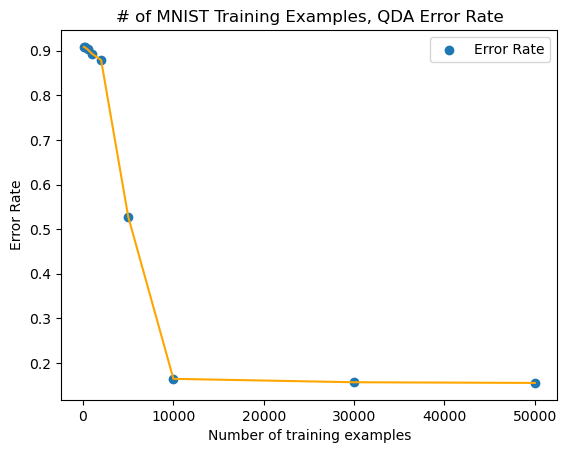

In [165]:
qda_scores = np.array([lst["accuracy"] for lst in qda_accuracies.values()])
qda_scores = (qda_scores - 1) * -1
plt.scatter(EXAMPLE_NUMBERS, qda_scores, label="Error Rate")
plt.plot(EXAMPLE_NUMBERS, qda_scores, color='orange')
plt.xlabel("Number of training examples")
plt.ylabel("Error Rate")
plt.title("# of MNIST Training Examples, QDA Error Rate")
plt.legend()

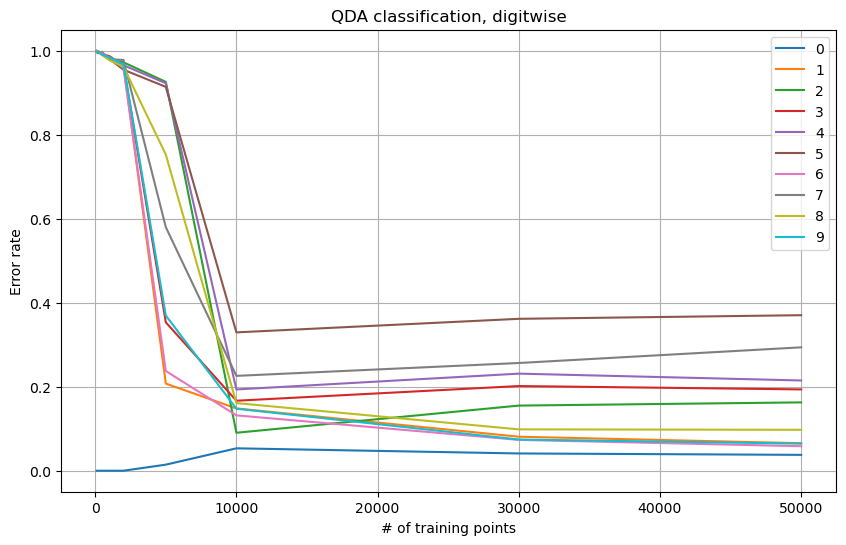

In [ ]:
def plot_validation_error(qda_accuracies, EXAMPLE_NUMBERS, y_test, X_test):
    plt.figure(figsize=(10, 6))

    for digit in range(10):
        error_rates = []
        digit_len = len(y_test[y_test == digit])

        for N in EXAMPLE_NUMBERS:
            predictions = qda_accuracies[N]['predictions'][-1] 
            pred_accuracy = np.sum((y_test == digit) & (predictions == digit)) / digit_len
            error_rates.append(1 - pred_accuracy)

        plt.plot(EXAMPLE_NUMBERS, error_rates, label=f'{digit}')

    plt.xlabel('# of training points')
    plt.ylabel('Error rate')
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(True)


plot_validation_error(qda_accuracies, EXAMPLE_NUMBERS, y_test, X_test)
plt.title('QDA classification, digitwise')
plt.show()

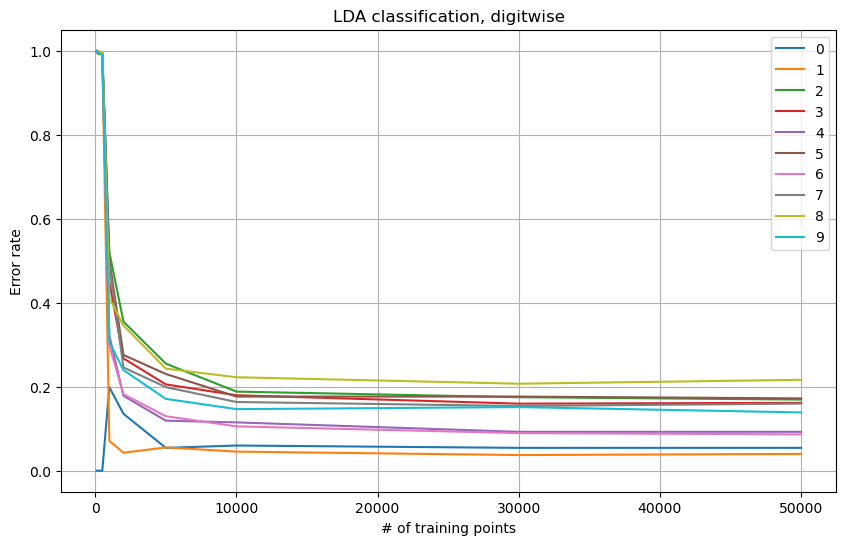

In [ ]:
plot_validation_error(lda_accuracies, EXAMPLE_NUMBERS, y_test, X_test)
plt.title('LDA classification, digitwise')
plt.show()

In [ ]:
test_data = full_data["test_data"]
test_data = test_data.reshape(test_data.shape[0], -1)
lda = LDA(shaped_data)
predictions = lda.predict(test_data)
results_to_csv(predictions, "mnistpredictions.csv")